# Import

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras import Model, layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import random
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# seed hold

random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)


def set_seeds(seed=random_seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)


def set_global_determinism(seed=random_seed, fast_n_close=False):

    set_seeds(seed=seed)
    if fast_n_close:
        return
        os.environ["TF_DETERMINISTIC_OPS"] = "1"
        os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
        tf.config.threading.set_inter_op_parallelism_threads(1)
        tf.config.threading.set_intra_op_parallelism_threads(1)
        from tfdeterminism import patch

        patch()


set_seeds()
set_global_determinism()

# Make dataset for train

In [3]:
# read_csv

path = "/content/gdrive/MyDrive/[KT,ETRI] 네트워크 지능화를 위한 인공지능 해커톤/데이터/데이터/Media/"
data1 = pd.read_csv(path + "Media_INFO.csv")
data2 = pd.read_csv(path + "Media_LOGIN.csv")
data3 = pd.read_csv(path + "Media_MENU.csv")
data4 = pd.read_csv(path + "Media_STREAM.csv")

In [4]:
# make all

all_data = pd.merge(data1, data2, on="Timestamp", how="inner")
all_data = pd.merge(all_data, data3, on="Timestamp", how="inner")
all_data = pd.merge(all_data, data4, on="Timestamp", how="inner")

In [5]:
# check

all_data.describe()

,INFO-01-Request,INFO-01-Success,INFO-01-Fail,LOGIN-01-Request,LOGIN-01-Success,LOGIN-01-Fail,LOGIN-02-Request,LOGIN-02-Success,LOGIN-02-Fail,LOGIN-03-Request,...,MENU-02-Fail,MENU-03-Request,MENU-03-Success,MENU-03-Fail,MENU-04-Request,MENU-04-Success,MENU-04-Fail,STREAM-01-Session,STREAM-02-Session,STREAM-03-Session
count,192249.000000,192249.000000,192249.0,209563.000000,209563.000000,209563.000000,192191.000000,192191.000000,192191.000000,192191.000000,...,209771.000000,209771.000000,209771.000000,209771.000000,209771.000000,209771.000000,209771.000000,178731.000000,178730.000000,209782.000000
mean,652.933035,652.933035,0.0,867.511708,832.565281,34.946427,870.019741,833.147889,36.871851,870.035902,...,17.617983,2266.175849,2248.552259,17.623590,2265.813883,2248.181870,17.632013,230.070777,293.673826,126.540585
std,400.472742,400.472742,0.0,554.134695,532.449705,44.918976,561.375468,538.678981,47.415618,561.565109,...,15.184931,1233.615763,1226.991766,15.156172,1233.142813,1226.477966,15.329928,117.847697,183.603586,61.666424
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,346.000000,346.000000,0.0,427.000000,416.000000,8.000000,422.000000,410.000000,9.000000,422.000000,...,8.000000,1348.000000,1337.000000,8.000000,1347.000000,1336.000000,8.000000,128.000000,129.000000,86.000000
50%,593.000000,593.000000,0.0,781.000000,751.000000,19.000000,783.000000,751.000000,21.000000,783.000000,...,14.000000,2127.000000,2108.000000,14.000000,2127.000000,2108.000000,14.000000,220.000000,223.000000,116.000000
75%,884.000000,884.000000,0.0,1182.000000,1123.000000,42.000000,1186.000000,1123.000000,45.000000,1186.000000,...,23.000000,2994.000000,2968.000000,23.000000,2994.000000,2968.000000,23.000000,315.000000,467.000000,156.000000
max,5952.000000,5952.000000,0.0,11503.000000,11234.000000,2177.000000,11502.000000,10920.000000,4288.000000,11499.000000,...,856.000000,24768.000000,24652.000000,818.000000,24942.000000,24806.000000,1041.000000,1007.000000,927.000000,782.000000


In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210240 entries, 0 to 210239
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Timestamp          210240 non-null  object 
 1   INFO-01-Request    192249 non-null  float64
 2   INFO-01-Success    192249 non-null  float64
 3   INFO-01-Fail       192249 non-null  float64
 4   LOGIN-01-Request   209563 non-null  float64
 5   LOGIN-01-Success   209563 non-null  float64
 6   LOGIN-01-Fail      209563 non-null  float64
 7   LOGIN-02-Request   192191 non-null  float64
 8   LOGIN-02-Success   192191 non-null  float64
 9   LOGIN-02-Fail      192191 non-null  float64
 10  LOGIN-03-Request   192191 non-null  float64
 11  LOGIN-03-Success   192191 non-null  float64
 12  LOGIN-03-Fail      192191 non-null  float64
 13  LOGIN-04-Request   209563 non-null  float64
 14  LOGIN-04-Success   209563 non-null  float64
 15  LOGIN-04-Fail      209563 non-null  float64
 16  LO

In [7]:
all_data["Timestamp"].iloc[0:10]

0    20170101_0000-0005
1    20170101_0005-0010
2    20170101_0010-0015
3    20170101_0015-0020
4    20170101_0020-0025
5    20170101_0025-0030
6    20170101_0030-0035
7    20170101_0035-0040
8    20170101_0040-0045
9    20170101_0045-0050
Name: Timestamp, dtype: object

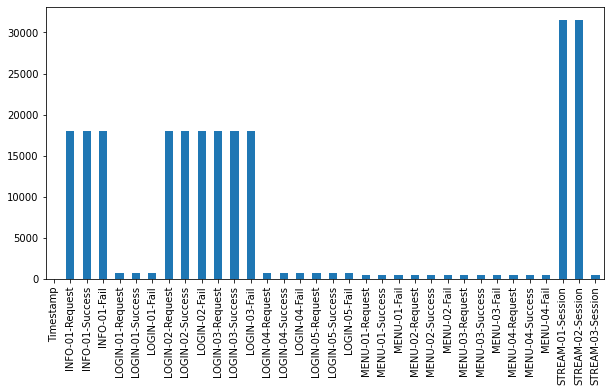

In [8]:
all_data.isna().sum().plot.bar(figsize = (10,5))

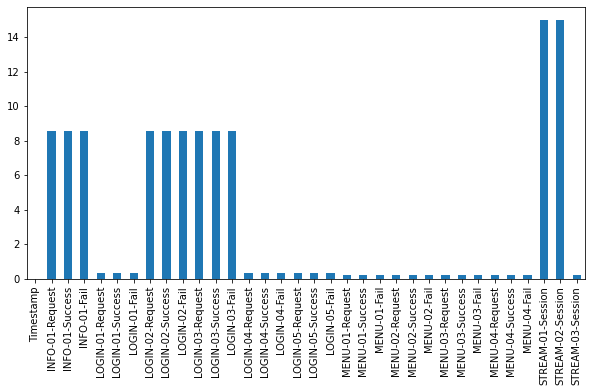

In [9]:
pd.DataFrame((all_data.isna().sum()/len(all_data)*100)).plot.bar(legend = False, figsize = (10,5))

In [10]:
date_time = all_data["Timestamp"].str.split("_",expand = True).rename(columns = {0:"date", 1:"time"})

In [11]:
year = date_time["date"].str.slice(start = 0, stop = 4)

In [12]:
month = date_time["date"].str.slice(start = 4, stop = 6)

In [13]:
day = date_time["date"].str.slice(start = 6, stop = 8)

In [14]:
time = date_time["time"].str.split("-", expand = True).rename(columns = {0:"hour",1:"sec"})

In [15]:
hour = time["hour"].str.slice(start = 0, stop = 2)

In [16]:
min = time["hour"].str.slice(start = 2, stop = 4)

In [17]:
time = year + "-" + month + "-" +day + " " + hour + ":"+ min

In [18]:
all_data["Timestamp"] = time.astype("Datetime64")

## 그래프 그리기

In [19]:
colname = all_data.columns

In [20]:
fillna = all_data["LOGIN-02-Request"].fillna(all_data["LOGIN-02-Request"].mean())

In [21]:
fillna[all_data["LOGIN-02-Request"].isna() == True]

0         870.019741
1         870.019741
2         870.019741
3         870.019741
4         870.019741
             ...    
200877    870.019741
200878    870.019741
200879    870.019741
200880    870.019741
200884    870.019741
Name: LOGIN-02-Request, Length: 18049, dtype: float64

Text(0.5, 1.0, 'After')

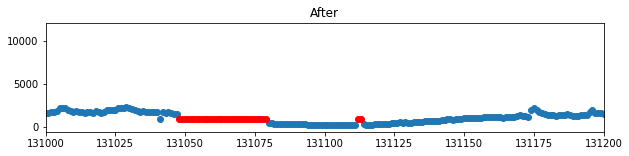

In [22]:
plt.figure(figsize = (10,2))
plt.scatter(np.arange(0,len(all_data))[all_data["LOGIN-02-Request"].isna() == False],fillna[all_data["LOGIN-02-Request"].isna() == False])
plt.scatter(np.arange(0,len(all_data))[all_data["LOGIN-02-Request"].isna() == True],fillna[all_data["LOGIN-02-Request"].isna() == True], color = "red")
plt.xlim(131000,131200)
plt.title("After")

Text(0.5, 1.0, 'Before')

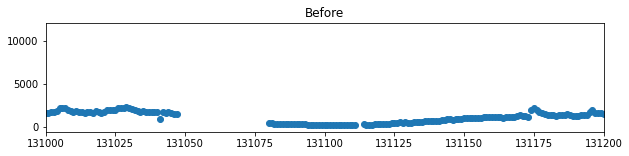

In [23]:
plt.figure(figsize = (10,2))
plt.scatter(np.arange(0,len(all_data))[all_data["LOGIN-02-Request"].isna() == False],fillna[all_data["LOGIN-02-Request"].isna() == False])
plt.xlim(131000,131200)
plt.title("Before")

Text(0.5, 1.0, 'INFO-01-Success')

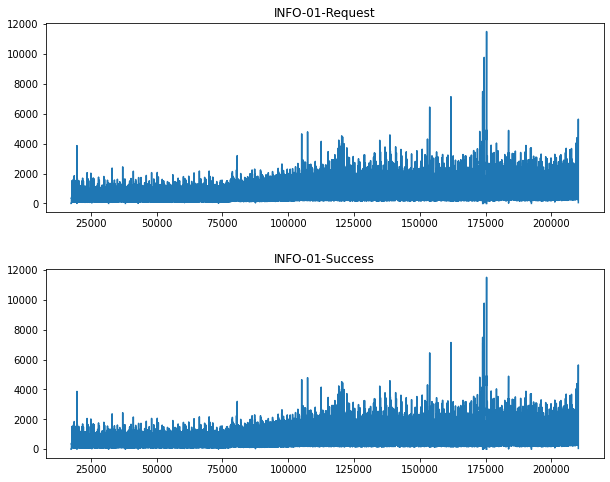

In [24]:
fig, ax = plt.subplots(2,1, figsize = (10,8))
plt.subplots_adjust(wspace = 0.15, hspace = 0.3)
ax[0].plot(all_data["LOGIN-02-Request"])
ax[0].set_title(colname[1])
ax[1].plot(all_data["LOGIN-02-Request"])
ax[1].set_title(colname[2])

Text(0.5, 1.0, 'LOGIN-01-Fail')

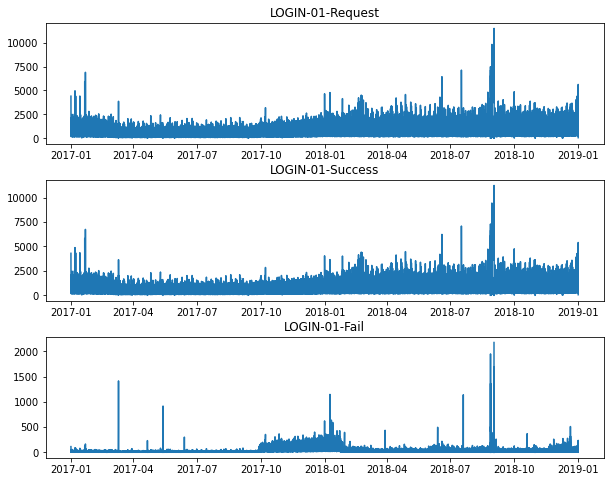

In [25]:
fig, ax = plt.subplots(3,1, figsize = (10,8))
plt.subplots_adjust(wspace = 0.15, hspace = 0.3)
ax[0].plot(all_data["Timestamp"],all_data[colname[4]])
ax[0].set_title(colname[4])
ax[1].plot(all_data["Timestamp"],all_data[colname[5]])
ax[1].set_title(colname[5])
ax[2].plot(all_data["Timestamp"],all_data[colname[6]])
ax[2].set_title(colname[6])

Text(0.5, 1.0, 'LOGIN-02-Fail')

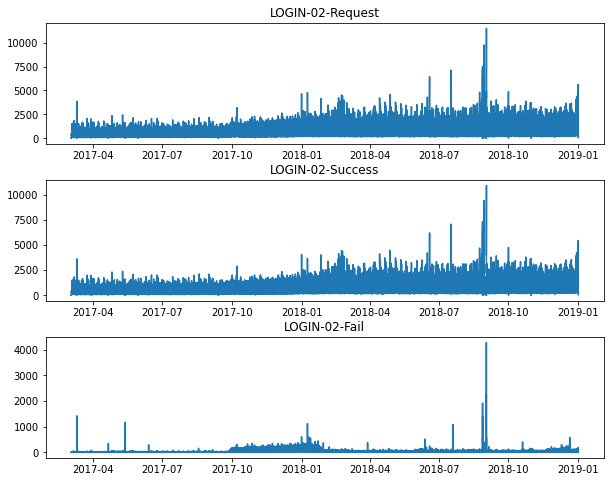

In [26]:
fig, ax = plt.subplots(3,1, figsize = (10,8))
plt.subplots_adjust(wspace = 0.15, hspace = 0.3)
ax[0].plot(all_data["Timestamp"],all_data[colname[7]])
ax[0].set_title(colname[7])
ax[1].plot(all_data["Timestamp"],all_data[colname[8]])
ax[1].set_title(colname[8])
ax[2].plot(all_data["Timestamp"],all_data[colname[9]])
ax[2].set_title(colname[9])

Text(0.5, 1.0, 'LOGIN-03-Fail')

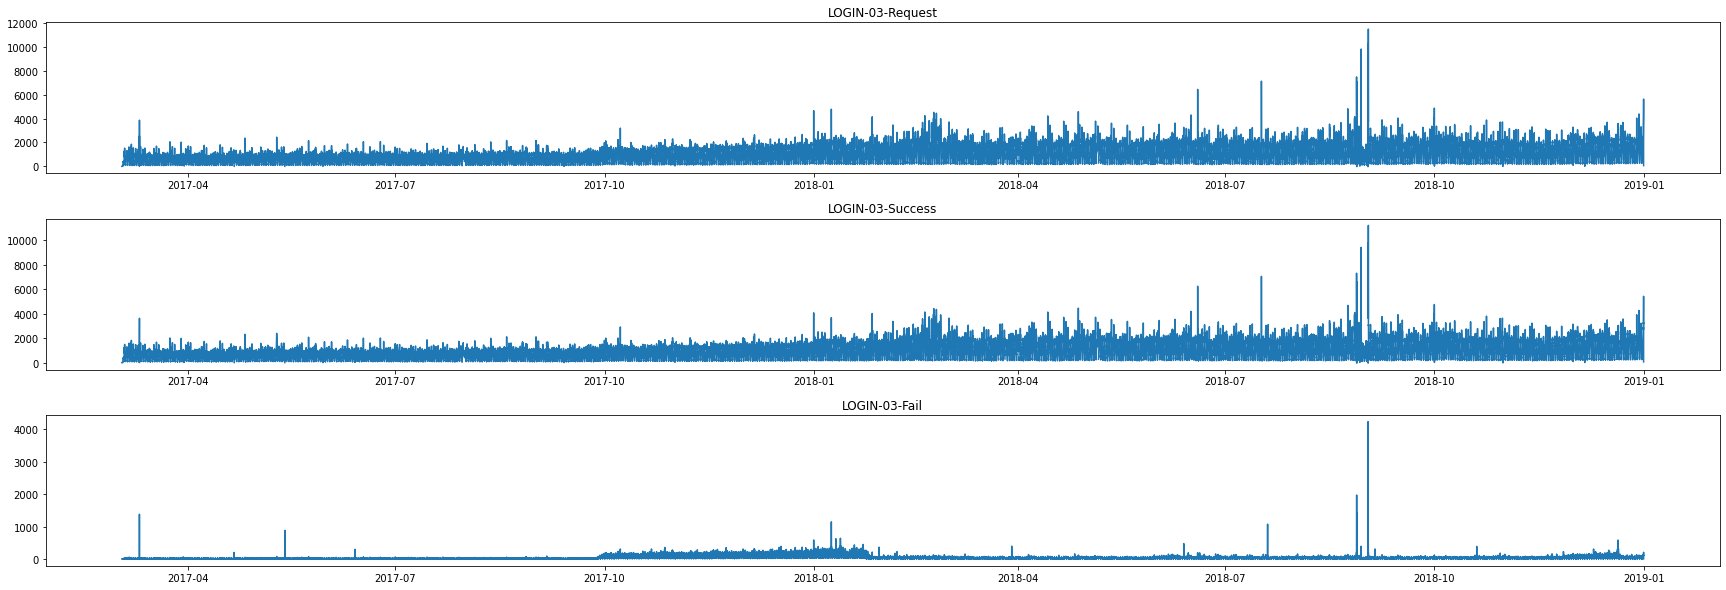

In [27]:
fig, ax = plt.subplots(3,1, figsize = (30,10))
plt.subplots_adjust(wspace = 0.15, hspace = 0.3)
ax[0].plot(all_data["Timestamp"],all_data[colname[10]])
ax[0].set_title(colname[10])
ax[1].plot(all_data["Timestamp"],all_data[colname[11]])
ax[1].set_title(colname[11])
ax[2].plot(all_data["Timestamp"],all_data[colname[12]])
ax[2].set_title(colname[12])

Text(0.5, 1.0, 'LOGIN-04-Fail')

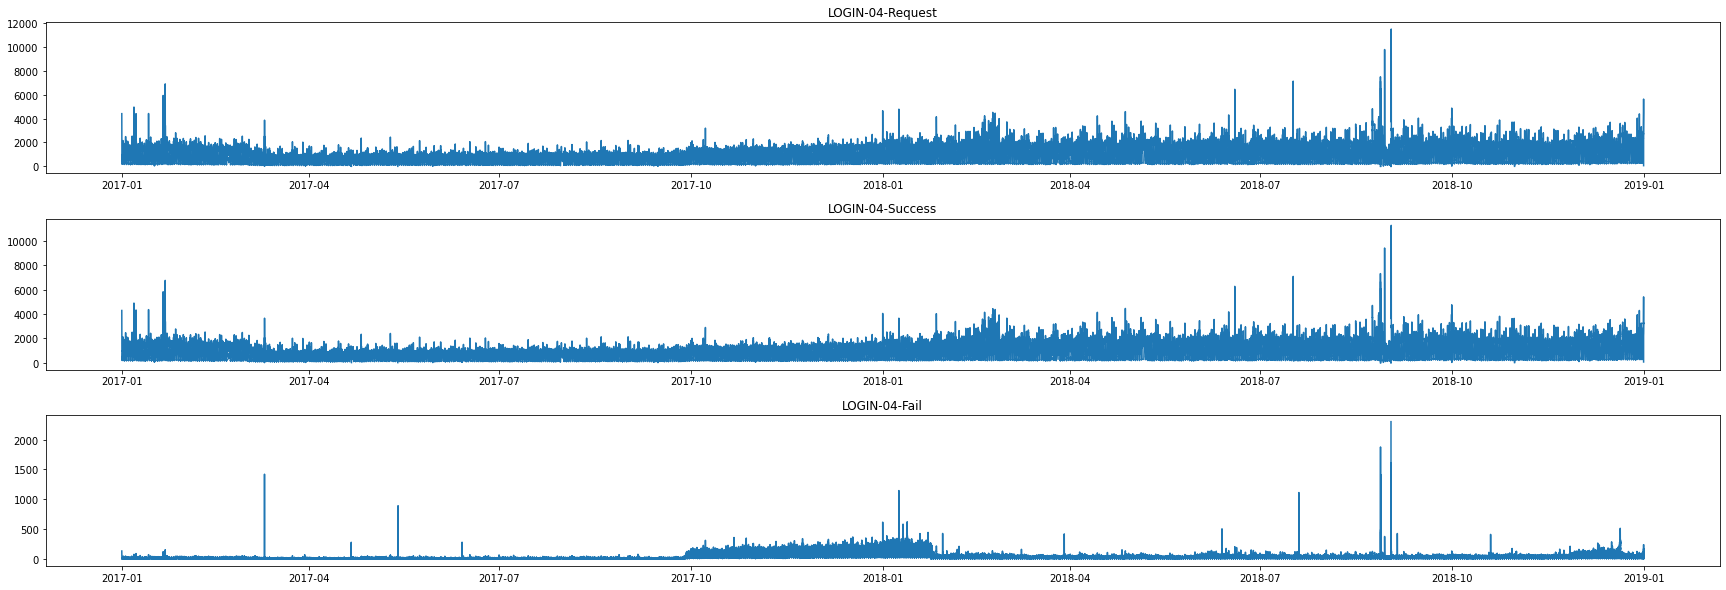

In [28]:
fig, ax = plt.subplots(3,1, figsize = (30,10))
plt.subplots_adjust(wspace = 0.15, hspace = 0.3)
ax[0].plot(all_data["Timestamp"],all_data[colname[13]])
ax[0].set_title(colname[13])
ax[1].plot(all_data["Timestamp"],all_data[colname[14]])
ax[1].set_title(colname[14])
ax[2].plot(all_data["Timestamp"],all_data[colname[15]])
ax[2].set_title(colname[15])

Text(0.5, 1.0, 'LOGIN-05-Fail')

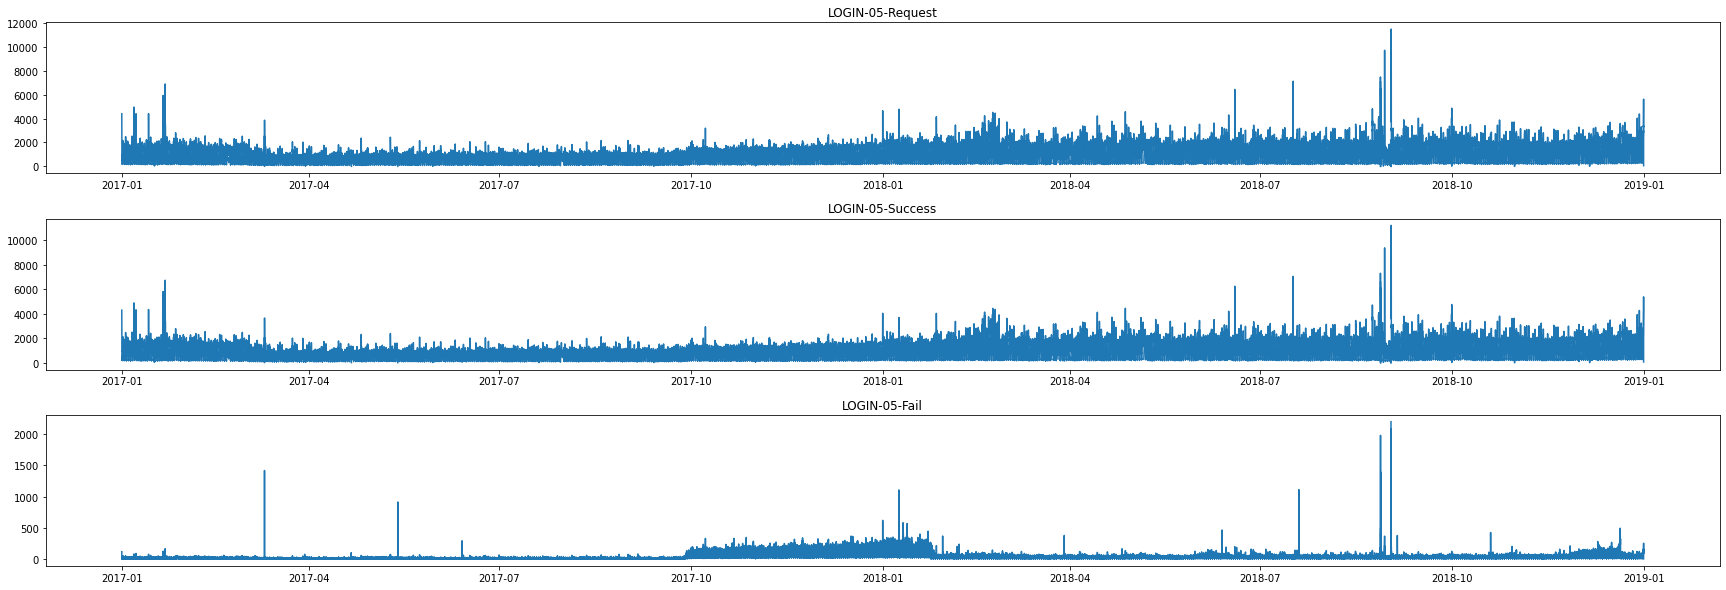

In [29]:
fig, ax = plt.subplots(3,1, figsize = (30,10))
plt.subplots_adjust(wspace = 0.15, hspace = 0.3)
ax[0].plot(all_data["Timestamp"],all_data[colname[16]])
ax[0].set_title(colname[16])
ax[1].plot(all_data["Timestamp"],all_data[colname[17]])
ax[1].set_title(colname[17])
ax[2].plot(all_data["Timestamp"],all_data[colname[18]])
ax[2].set_title(colname[18])

Text(0.5, 1.0, 'MENU-01-Fail')

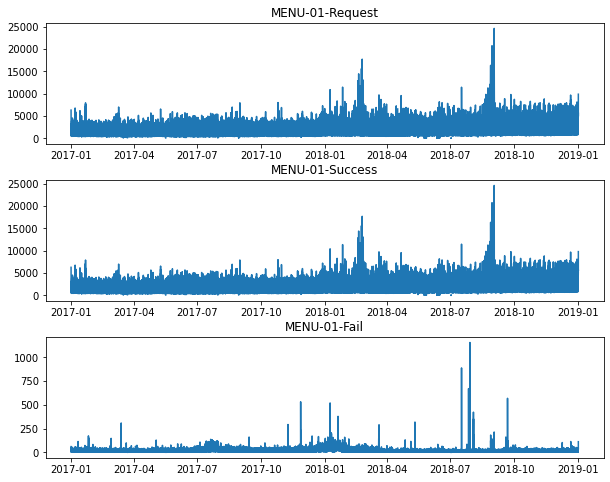

In [30]:
fig, ax = plt.subplots(3,1, figsize = (10,8))
plt.subplots_adjust(wspace = 0.15, hspace = 0.3)
ax[0].plot(all_data["Timestamp"],all_data[colname[19]])
ax[0].set_title(colname[19])
ax[1].plot(all_data["Timestamp"],all_data[colname[20]])
ax[1].set_title(colname[20])
ax[2].plot(all_data["Timestamp"],all_data[colname[21]])
ax[2].set_title(colname[21])

Text(0.5, 1.0, 'MENU-02-Fail')

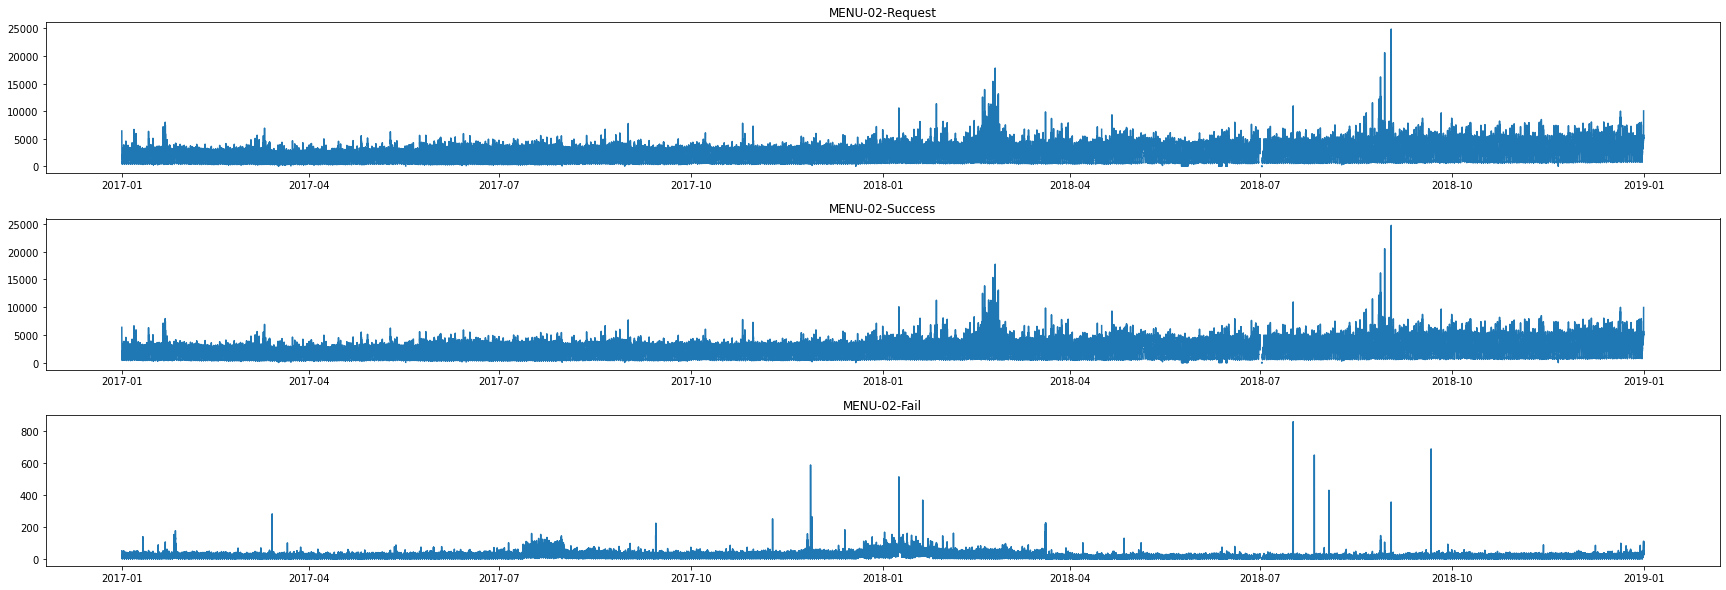

In [31]:
fig, ax = plt.subplots(3,1, figsize = (30,10))
plt.subplots_adjust(wspace = 0.15, hspace = 0.3)
ax[0].plot(all_data["Timestamp"],all_data[colname[22]])
ax[0].set_title(colname[22])
ax[1].plot(all_data["Timestamp"],all_data[colname[23]])
ax[1].set_title(colname[23])
ax[2].plot(all_data["Timestamp"],all_data[colname[24]])
ax[2].set_title(colname[24])

Text(0.5, 1.0, 'MENU-03-Fail')

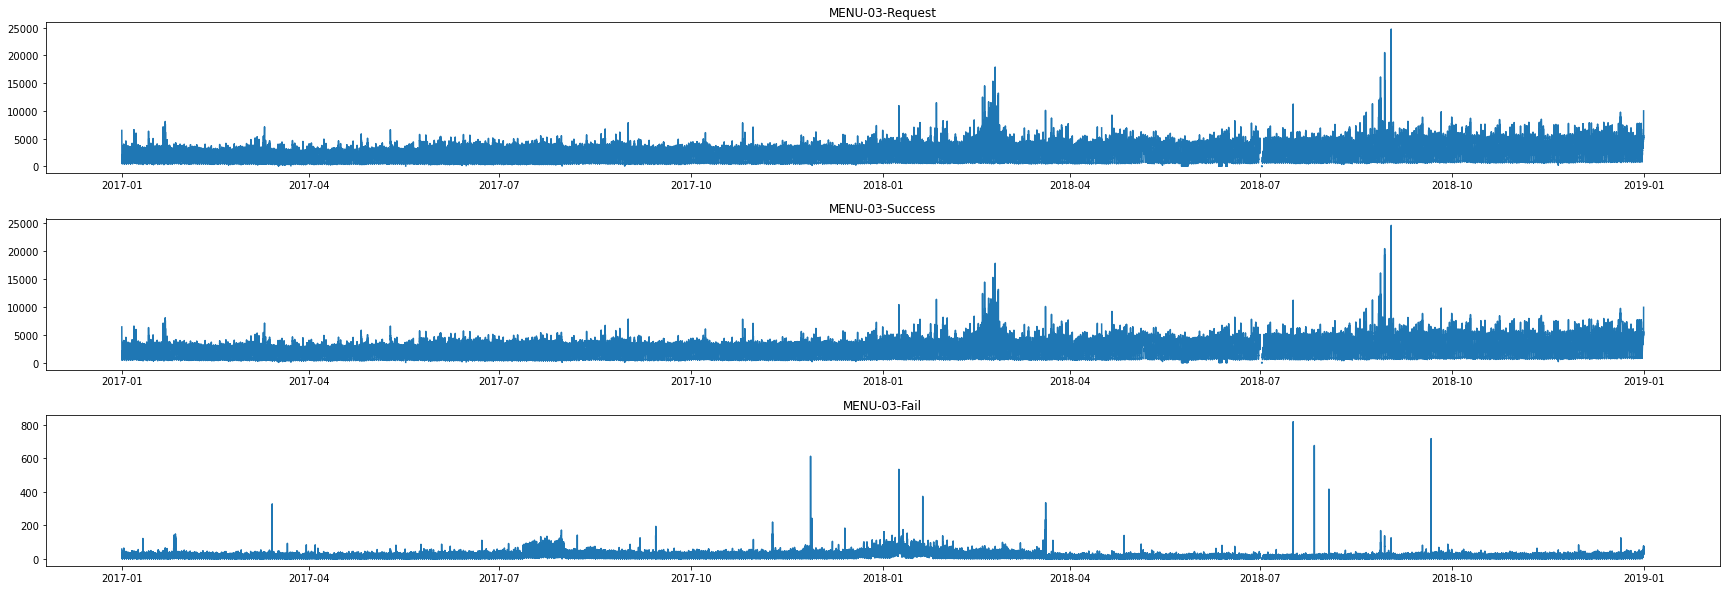

In [32]:
fig, ax = plt.subplots(3,1, figsize = (30,10))
plt.subplots_adjust(wspace = 0.15, hspace = 0.3)
ax[0].plot(all_data["Timestamp"],all_data[colname[25]])
ax[0].set_title(colname[25])
ax[1].plot(all_data["Timestamp"],all_data[colname[26]])
ax[1].set_title(colname[26])
ax[2].plot(all_data["Timestamp"],all_data[colname[27]])
ax[2].set_title(colname[27])

Text(0.5, 1.0, 'MENU-04-Fail')

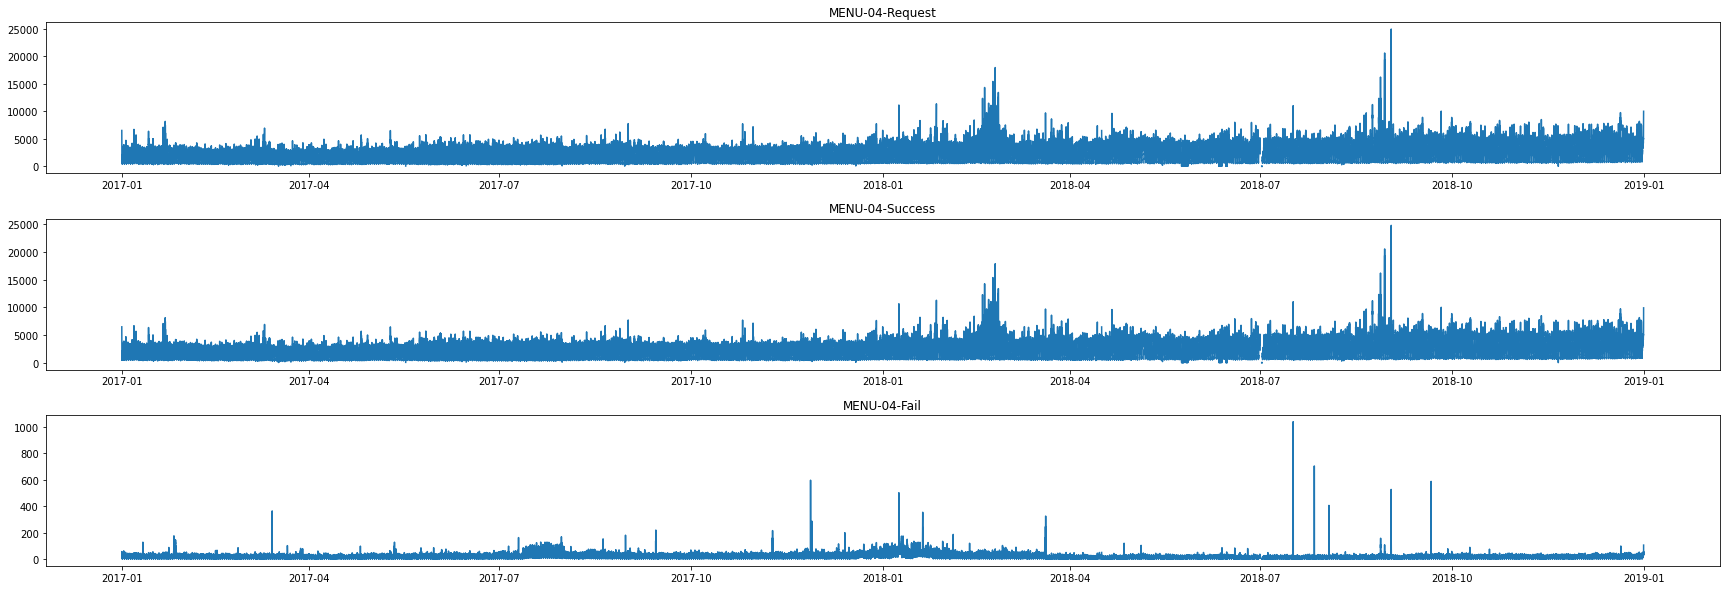

In [33]:
fig, ax = plt.subplots(3,1, figsize = (30,10))
plt.subplots_adjust(wspace = 0.15, hspace = 0.3)
ax[0].plot(all_data["Timestamp"],all_data[colname[28]])
ax[0].set_title(colname[28])
ax[1].plot(all_data["Timestamp"],all_data[colname[29]])
ax[1].set_title(colname[29])
ax[2].plot(all_data["Timestamp"],all_data[colname[30]])
ax[2].set_title(colname[30])

Text(0.5, 1.0, 'STREAM-03-Session')

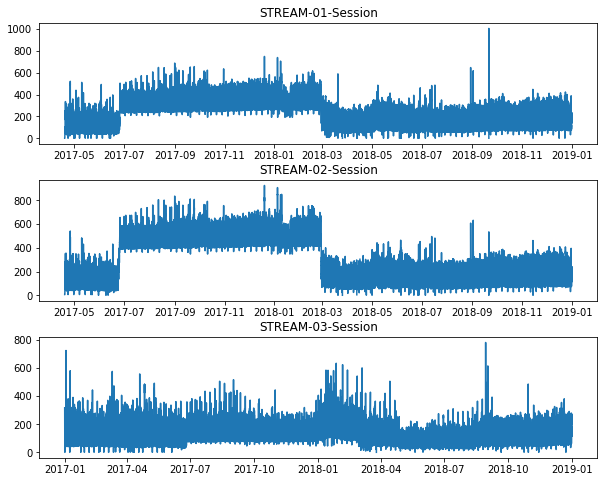

In [34]:
fig, ax = plt.subplots(3,1, figsize = (10,8))
plt.subplots_adjust(wspace = 0.15, hspace = 0.3)
ax[0].plot(all_data["Timestamp"],all_data[colname[31]])
ax[0].set_title(colname[31])
ax[1].plot(all_data["Timestamp"],all_data[colname[32]])
ax[1].set_title(colname[32])
ax[2].plot(all_data["Timestamp"],all_data[colname[33]])
ax[2].set_title(colname[33])

In [35]:
# drop

all_data.drop(["Timestamp"], inplace=True, axis=1)

In [36]:
# fillna mean

all_data = all_data.fillna(all_data.mean())

In [37]:
# copy data

train = all_data.copy()
train.shape

(210240, 33)

## Transform to sequence

In [38]:
i = 1
j = 1
temp = []
for j in range(1,6) :
    temp.append(train.iloc[[(i + j + 1)],:])

print(np.array(temp).shape)
print(np.squeeze(np.array(temp)).shape) #  크기 1인 축 제거

(5, 1, 33)
(5, 33)


In [39]:
def to_seq(df, step):
    output = []
    for i in range(len(df) - step - 1):
        temp = []
        for j in range(1, step + 1):
            temp.append(df.loc[[(i + j + 1)], :])
        output.append(temp)
    return np.squeeze(np.array(output))

In [40]:
 step = abs(5)
# trans_train = to_seq(train, step)
# trans_train.shape

In [41]:
import pickle

# # 데이터 저장
# with open('/content/gdrive/MyDrive/[KT,ETRI] 네트워크 지능화를 위한 인공지능 해커톤/데이터/3d_data.pkl', 'wb') as f:
# 	pickle.dump(trans_train, f)
    
# 데이터 로드
with open('/content/gdrive/MyDrive/[KT,ETRI] 네트워크 지능화를 위한 인공지능 해커톤/데이터/3d_data.pkl', 'rb') as f:
	trans_train = pickle.load(f)

In [42]:
train_seq = trans_train

## dimemsion down & feature scale

In [43]:
def dimension_down(df):
    dimension_df = np.empty((df.shape[0], df.shape[2]))
    for i in range(df.shape[0]):
        dimension_df[i] = df[i, (df.shape[1] - 1), :]

    return dimension_df


def scaling(df, scaler):
    for i in range(df.shape[0]):
        df[i, :, :] = scaler.transform(df[i, :, :])


    return df

In [44]:
print(dimension_down(train_seq).shape)

(210234, 33)


In [45]:
trans_train.shape[0]

210234

In [46]:
scaler = RobustScaler().fit(dimension_down(train_seq))
train_scaled = scaling(trans_train, scaler)
print(train_scaled.shape)

(210234, 5, 33)


## LSTM AE for trainset

In [47]:
def lstm_autoencoder():
    feature_number = train_scaled.shape[2]
    lstm_ae = models.Sequential()

    # Encoding
    lstm_ae.add(layers.LSTM(128, activation="relu", input_shape=(step, feature_number), return_sequences=True))
    lstm_ae.add(layers.LSTM(64, activation="relu", return_sequences=False))
    lstm_ae.add(layers.RepeatVector(step))

    # Decoding
    lstm_ae.add(layers.LSTM(64, activation="relu", return_sequences=True))
    lstm_ae.add(layers.LSTM(128, activation="relu", return_sequences=True))
    lstm_ae.add(layers.TimeDistributed(layers.Dense(feature_number)))

    print(lstm_ae.summary())
    return lstm_ae

In [48]:
lstm_ae0 = lstm_autoencoder()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            82944     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVector  (None, 5, 64)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 5, 64)             33024     
                                                                 
 lstm_3 (LSTM)               (None, 5, 128)            98816     
                                                                 
 time_distributed (TimeDistr  (None, 5, 33)            4257      
 ibuted)                                                

In [49]:
# # set parameter

# epochs = 20
# batch_size = 128
# learning_rate = 0.001
# validation = 0.2

In [50]:
# # compile

# lstm_ae0.compile(loss="mse", optimizer=optimizers.Adam(learning_rate))

In [51]:
# # fit

# history = lstm_ae0.fit(
#     train_scaled,
#     train_scaled,
#     epochs=epochs,
#     batch_size=batch_size,
#     validation_split=validation,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
#     ],
# )

X = train_scaled
y = train_scaled

얼마나 모델이 현재의 값을 구현을 잘 하냐를 확인

In [52]:
# # history

# plt.plot(history.history["loss"], label="Train Loss")
# plt.plot(history.history["val_loss"], label="Valid Loss")
# plt.legend()
# plt.show()

In [110]:
# model load

lstm_ae0 = tf.keras.models.load_model('/content/gdrive/MyDrive/[KT,ETRI] 네트워크 지능화를 위한 인공지능 해커톤/서류/Media/Media_전처리모델.h5')

In [111]:
train_predictions = lstm_ae0.predict(train_scaled)

In [112]:
print(train_scaled.shape)
print(train_predictions.shape)

(210234, 5, 33)
(210234, 5, 33)


In [113]:
threshold = 0.2

In [114]:
error = []
for i in range(len(train_scaled)) :
    error.append(np.sqrt(np.mean(np.power(train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2])[i] - train_scaled.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2])[i], 2))))

In [115]:
# rmse를 이용해 1차적으로 anormaly 걸러내기

train_error = []
for i in range(len(train_scaled)):
    if np.sqrt(np.mean(np.power(train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2])[i] - train_scaled.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2])[i], 2))) > threshold:
        train_error.append(1)
    else:
        train_error.append(0)

In [127]:
error = pd.DataFrame(error).rename(columns = {0:"error"})

,error
0,0.045119
1,0.043770
2,0.044042
3,0.043630
4,0.043676
...,...
210229,0.066541
210230,0.068242
210231,0.068206
210232,0.073952


In [117]:
train_error = pd.DataFrame(train_error).rename(columns = {0:"train_error"})

In [128]:
np.mean(error["error"]) + np.std(error["error"]) * 20

0.24569687345317792

In [62]:
error_df = pd.concat([error, train_error],axis = 1)

(0.0, 5.0)

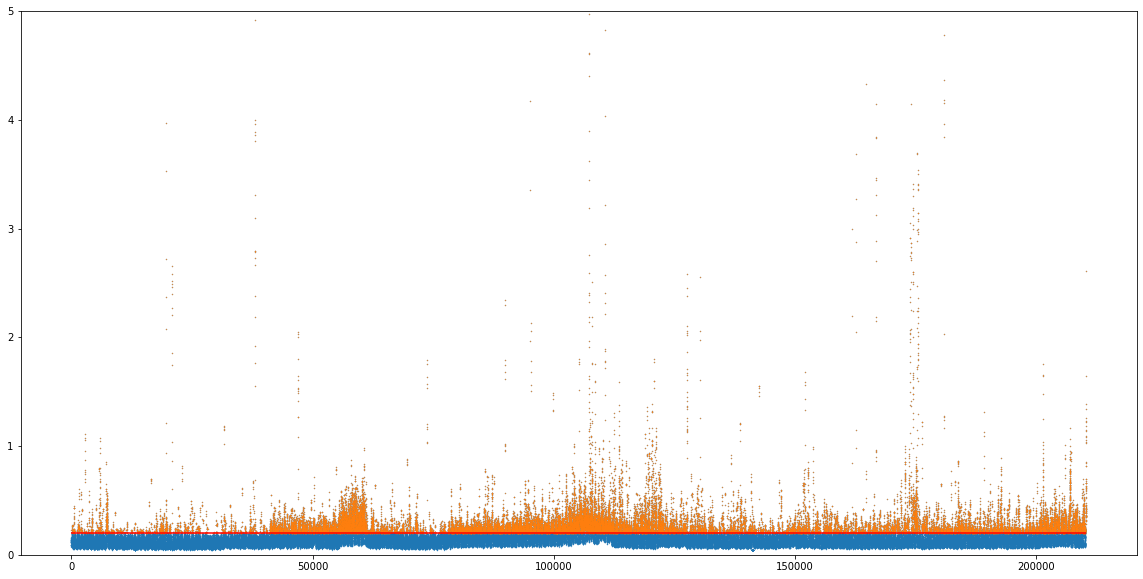

In [63]:
plt.figure(figsize = (20,10))
plt.scatter(error_df.index,error_df["error"],s = 0.1)
plt.scatter(error_df[error_df["train_error"] == 1].index,error_df[error_df["train_error"] == 1]["error"],s = 0.1)
plt.hlines(0.2,0,len(error_df),color = "red")
plt.ylim(0,5)

(0.0, 5.0)

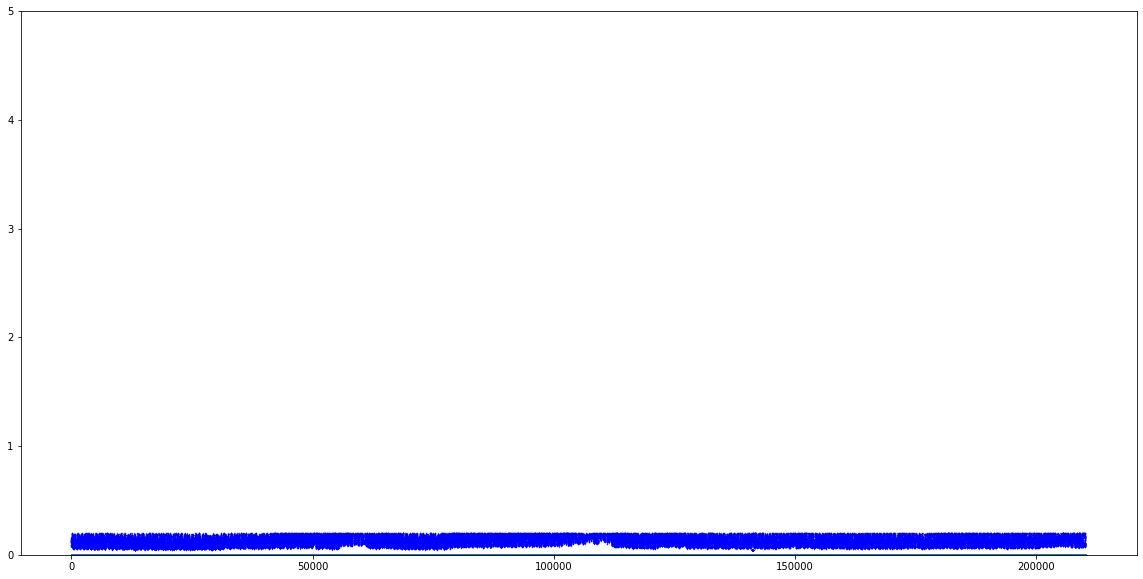

In [76]:
plt.figure(figsize = (20,10))
plt.scatter(error_df.index,np.zeros(len(error_df["error"])),s = 0.1)
plt.scatter(error_df[error_df["train_error"] == 0].index,error_df[error_df["train_error"] == 0]["error"],s = 0.1, c= "blue")
plt.ylim(0,5)

In [64]:
train_error = pd.DataFrame(train_error, columns=['Prediction'])
train_error.value_counts()

Series([], dtype: int64)

In [65]:
err_index = list(train_error[train_error['Prediction'] == 1].index)

In [66]:
r_train = train.drop(err_index)
r_train.reset_index(drop=True, inplace=True)

# Prepare dataset for test

In [67]:
test = all_data[105120:]
test.reset_index(drop=True, inplace=True)

## Transform to sequence

In [77]:
trans_train = to_seq(r_train, step)
trans_test = to_seq(test, step)
print(trans_test.shape)

(105114, 5, 33)


In [78]:
train_seq = trans_train

## dimension down & feature scale

In [79]:
scaler = MinMaxScaler().fit(dimension_down(train_seq))
train_scaled = scaling(trans_train, scaler)
test_scaled = scaling(trans_test, scaler)
print(train_scaled.shape)
print(test_scaled.shape)

(210234, 5, 33)
(105114, 5, 33)


## LSTM AE for testset

In [80]:
def lstm_autoencoder2():
    feature_number = train_scaled.shape[2]
    lstm_ae = models.Sequential()

    # Encoding
    lstm_ae.add(layers.LSTM(64, activation="relu", input_shape=(step, feature_number), return_sequences=True))
    lstm_ae.add(layers.LSTM(32, activation="relu", return_sequences=False))
    lstm_ae.add(layers.RepeatVector(step))

    # Decoding
    lstm_ae.add(layers.LSTM(32, activation="relu", return_sequences=True))
    lstm_ae.add(layers.LSTM(64, activation="relu", return_sequences=True))
    lstm_ae.add(layers.TimeDistributed(layers.Dense(feature_number)))

    print(lstm_ae.summary())
    return lstm_ae

In [81]:
lstm_ae1 = lstm_autoencoder2()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 64)             25088     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 5, 32)            0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 5, 32)             8320      
                                                                 
 lstm_7 (LSTM)               (None, 5, 64)             24832     
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 33)            2145      
 tributed)                                            

In [82]:
# # set parameter

# epochs = 10
# batch_size = 128
# learning_rate = 0.001
# validation = 0.2

In [83]:
# # compile

# lstm_ae1.compile(loss="mse", optimizer=optimizers.Adam(learning_rate))

In [84]:
# # fit

# history = lstm_ae1.fit(
#     train_scaled,
#     train_scaled,
#     epochs=epochs,
#     batch_size=batch_size,
#     validation_split=validation,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
#     ],
# )

# detect anormal

## test mse loss

In [87]:
# model load
lstm_ae1 = tf.keras.models.load_model("/content/gdrive/MyDrive/[KT,ETRI] 네트워크 지능화를 위한 인공지능 해커톤/서류/Media/Media_이상탐지모델.h5")

In [88]:
test_predictions = lstm_ae1.predict(test_scaled)

In [89]:
threshold = 0.1

In [91]:
error = []
for i in range(len(test_scaled)):
    error.append(np.sqrt(np.mean(np.power(test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * test_predictions.shape[2])[i] - test_scaled.reshape(test_predictions.shape[0], test_predictions.shape[1] * test_predictions.shape[2])[i], 2)))

In [94]:
error = pd.DataFrame(error).rename(columns = {0:"error"})
error

,error
0,0.024467
1,0.023315
2,0.024427
3,0.023235
4,0.022552
...,...
105109,0.148989
105110,0.154791
105111,0.169715
105112,0.220475


In [90]:
# rmse를 이용해 2차적으로 anormaly detect

predict = []
for i in range(len(test_scaled)):
    if np.sqrt(np.mean(np.power(test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * test_predictions.shape[2])[i] - test_scaled.reshape(test_predictions.shape[0], test_predictions.shape[1] * test_predictions.shape[2])[i], 2))) > threshold:
        predict.append(1)
    else:
        predict.append(0)

for _ in range(step+1):
    predict.append(predict[-1])

In [95]:
predict = pd.DataFrame(predict, columns=['Prediction'])
predict.value_counts()

Prediction
0             105008
1                112
dtype: int64

In [97]:
df=pd.concat([error,predict],axis = 1)

In [106]:
np.mean(error["error"])

0.012014250275184657

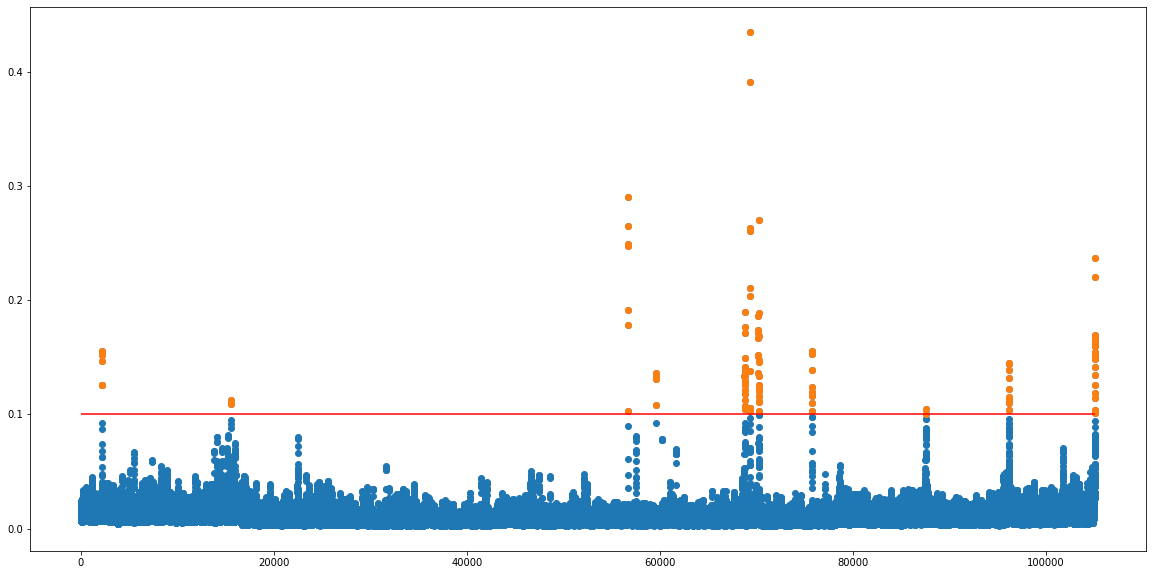

In [103]:
plt.figure(figsize = (20,10))
plt.scatter(df.index,df["error"])
plt.scatter(df[df["Prediction"] == 1].index,df[df["Prediction"] == 1]["error"])
plt.hlines(0.1,0,len(df),color = "red")

In [ ]:
predict[predict['Prediction']==1]

In [ ]:
#predict.to_csv('predict.csv', mode='w')